# Strategies for Handling Missing Values for Machine Learning Projects

In [4]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [ ]:
#install xgboost
%pip install xgboost

In [1]:
from xgboost import XGBClassifier

**The types of missing data a data scientist has to deal with include**:

- Missing Completely At Random(MCAR): there is no relationship between the missing data and the other values in the dataset. The missing values are completely independent of the observed values.

- Missing At Random (MAR): missing data is correlated with other observed values. In this case the data is missing in a specific pattern. The pattern of missingness can be explained by a variable for which we have information about the cause of the missingness.

- Missing Not At Random (MNAR): the missing data is due to unobserved data & cannot be explained by other observed data. There is pattern that cannot be explained by the observed data.

### 1. Missing Value Analysis

understanding the nature of the missing values in the data

In [5]:
df = pd.read_csv('files/heart_disease_uci.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [7]:
#function to return the proportion of missing values in the data
def missing_values(df):
    missing_values = df.isnull().sum()
    missing_values_pct = (df.isnull().sum() / len(df)) * 100
    
    missing_values_table = pd.concat([missing_values,
                                      missing_values_pct],
                                      axis=1)
    table_renamed_columns = missing_values_table.rename(columns={0: 'missing_values',
                                                                     1: 'pct_of_total_values'})
    table_renamed_columns = (table_renamed_columns[table_renamed_columns.iloc[:, 1] != 0]
                                 .sort_values(by='pct_of_total_values', ascending=False)
                                 .round(1))
    
    print(f'''Select dataframe has {str(df.shape[1])} columns.
         There are {str(table_renamed_columns.shape[0])} columns that have missing values''')
    
    return table_renamed_columns

In [8]:
missing_values_table = missing_values(df)
missing_values_table

Select dataframe has 16 columns.
         There are 10 columns that have missing values


,missing_values,pct_of_total_values
ca,611,66.4
thal,486,52.8
slope,309,33.6
fbs,90,9.8
oldpeak,62,6.7
trestbps,59,6.4
exang,55,6.0
thalch,55,6.0
chol,30,3.3
restecg,2,0.2


<Axes: >

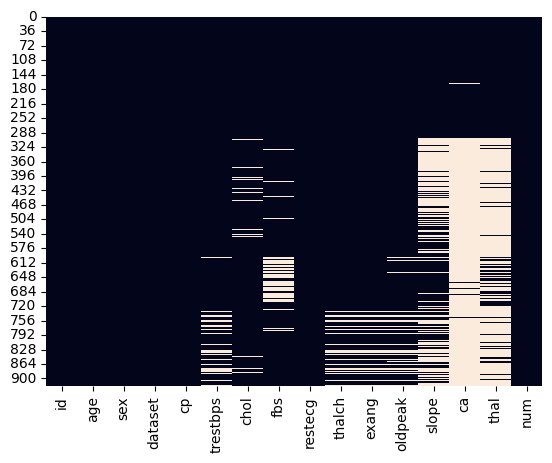

In [30]:
#visualizing missingness in dataframe
sns.heatmap(df.isnull(), cbar=False)

In the plot above, a missing value appears as a thin white line in each column.  
It appears the column ca has the most missing values, followed by thal, then slope.
Columns like age, sex and cp appear to have no missing value, since there is not  a single white line appearing along them.

Also, it appears the most missing values in the rows are in the 540th  row and below

### 2. Methods for Handling Missing Data

**a.** **Using XGBoost to Ignore Missing Data**

XGBoost is one of few models that can handle dataset with missing values and may not harm model performance.
In the function for reading the data below, the categorical columns are encoded to improve model performance

In [9]:
# reusable function for reading data
def read_data(path):
    """
    Read the dataset, prepare and encode categorical columns

    Parameter:
    - path (str): The path to the dataset

    Returns:
    - df (pd.DataFrame): The dataset with encoded categorical columns
    """
    df = pd.read_csv(path)
    df['num'] = df['num'].replace({2: 1, 3: 1, 4: 1})
    df = df.drop('id', axis=1)
    df[df.select_dtypes('object').columns] = df.select_dtypes('object').apply(lambda x: x.astype('category'))
    categorical_columns = df.select_dtypes('category').columns
                            
    #encode categorical columns
    label_encoder = LabelEncoder()
                                                                              
    for column in categorical_columns:
         df[column] = label_encoder.fit_transform(df[column])
    return df                                              

In [10]:
# read and process dataset
path = 'files/heart_disease_uci.csv'
df = read_data(path)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   dataset   920 non-null    int64  
 3   cp        920 non-null    int64  
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       920 non-null    int64  
 7   restecg   920 non-null    int64  
 8   thalch    865 non-null    float64
 9   exang     920 non-null    int64  
 10  oldpeak   858 non-null    float64
 11  slope     920 non-null    int64  
 12  ca        309 non-null    float64
 13  thal      920 non-null    int64  
 14  num       920 non-null    int64  
dtypes: float64(5), int64(10)
memory usage: 107.9 KB


In [11]:
# function prepare the data for model training
def split_dataset(df):
    '''
    Splits dataset into training and testing sets
    
    Parameters:
    - df (pd.DataFrame): The input dataset.
    
    Returns:
    - X_train, X_test, y_train, y_test: Training & testing sets for features & labels
    '''
    X = df.drop('num', axis=1)
    y = df['num']
    
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                       test_size=.2,
                                                       random_state=42)
    return X_train, X_test, y_train, y_test

In [ ]:
#train an Extreme Gradient Boosting Model
def train_model_XGBoost(X_train, X_test, y_train, y_test):
    '''
    Trains an XGBoost model on the given training set
    and evaluates its performance on the test set.
    
    Parameters:
    - X_train, X_test, y_train, y_test : training set of features and the label

    Returns:
    - Accuracy (float) of the xgboost model
    '''
    
    #instantiate and fit data to XGBoost model
    xgboost = XGBClassifier()
    xgboost.fit(X_train, y_train)
    
    #evaluate model with test set
    accuracy = xgboost.score(X_test, y_test)
    print(f'Accuracy: {accuracy}\n')
    return accuracy

In [17]:
#split dataset into train and test sets
X_train, X_test, y_train, y_test = split_dataset(df)

#Train an XGBoost model on the dataset without handling missing values
accuracy_no_handling = train_model_XGBoost(X_train, X_test, y_train, y_test)

Accuracy: 0.8586956521739131



In [18]:
#dictionary to store accuracies for comparison
accuracies = {}

In [19]:
#store accuracy of model in dictionary
accuracies['xgboost'] = accuracy_no_handling

# A specific data, after the procedure
print("\n------------------\n")
print("\nAfter Imputation: \n")
X_train[(X_train['age']==58.0) & (X_train['sex']==1.0) & (X_train['dataset']==3.0) & (X_train['chol']==385)]


------------------


After Imputation: 



,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal
918,58,1,3,0,NaN,385.0,1,0,NaN,2,NaN,3,NaN,3


This method is preferable for creating a quick prototype at the beginning of the project.  
If missing data represent some important patterns in data, this method may not yield the best accuracy.

**b.** **Delete Missing Data**

Categories of deletion include:

- Pairwise Deletion.  
It is employed when the proportion of missing datapoints is less than 20% of the data.  
It is ideal when missing values are randomly distributed  

Most reasonable use case: MCAR

In [21]:
#read & process dataset
df_pairwise = df.dropna()
df_pairwise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 308 entries, 0 to 759
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       308 non-null    int64  
 1   sex       308 non-null    int64  
 2   dataset   308 non-null    int64  
 3   cp        308 non-null    int64  
 4   trestbps  308 non-null    float64
 5   chol      308 non-null    float64
 6   fbs       308 non-null    int64  
 7   restecg   308 non-null    int64  
 8   thalch    308 non-null    float64
 9   exang     308 non-null    int64  
 10  oldpeak   308 non-null    float64
 11  slope     308 non-null    int64  
 12  ca        308 non-null    float64
 13  thal      308 non-null    int64  
 14  num       308 non-null    int64  
dtypes: float64(5), int64(10)
memory usage: 38.5 KB


From the output above missing values have been removed from the dataset  
After peforming pairwise deletion on the data, a random forest will be trained on the data to see its performance

In [22]:
#split dataset into train and test sets
X_train, X_test, y_train, y_test = split_dataset(df_pairwise)

In [25]:
#train the prepared data on a Random Forest Classifier
def train_model_RF(X_train, X_test, y_train, y_test):
    '''
    Trains RandomForestClassifier model on the training set
    and evaluates it on the test set.
    
    Parameter:
    - X_train, X_test, y_train, y_test: training set
    of features and label.
    
    Returns:
    - accuracy (float) of Random Forest model
    '''
    #instantiate and train RandomForestClassifier
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train, y_train)
    
    #Evaluate model with test set
    accuracy = rf_model.score(X_test, y_test)
    print(f'Accuracy: {accuracy}\n')
    return accuracy

NB: The Random Forest classifier function will be used to train the rest of the models

In [26]:
accuracy_pairwise = train_model_RF(X_train, X_test, y_train, y_test)

accuracies['Pairwise'] = accuracy_pairwise

Accuracy: 0.8548387096774194



- Listwise Deletion  
Deleting based on missingness in a list of specified variables (columns/features).  
This method is useful when the missingness is not random and the missingness is not related to the target variable.  
This method is not recommended for small datasets as it can lead to loss of information.  

Reasonable use case: MCAR

In [28]:
#drop columns with missing values
df_listwise = df.dropna(subset=['thal', 'slope', 'ca', 'fbs'])

#split dataset into train and test sets
X_train, X_test, y_train, y_test = split_dataset(df_listwise)

In [29]:
#save accuracy of model in dictionary
accuracy_listwise = train_model_RF(X_train, X_test, y_train, y_test)

accuracies['Listwise'] = accuracy_listwise

Accuracy: 0.8387096774193549



- Dropping Entire Columns  
Used when columns to delete are of little to no importance for analysis  
Or when they contain a large number of missing values

Reasonable use case: any type of missingness, if feature is not relevant

In [30]:
#read and process dataset
df_entire_col = df.dropna(axis=1)

X_train, X_test, y_train, y_test = split_dataset(df_entire_col)

accuracy_entire_col = train_model_RF(X_train, X_test, y_train, y_test)

accuracies['Entire Columns'] = accuracy_entire_col

Accuracy: 0.8260869565217391



#### 3. Statistical Methods for Handing Missing Data

The mean is the most common missing values imputation method for numeric columns  
It is not appropriate if data has outliers  

The Median is best used when there are outliers in the dataset

Reasonable use case: MCAR

In [31]:
#function to train data on specified statistic
def impute_and_train(X_train, X_test, y_train, y_test, strategy):
    '''
    Imputes missing values in dataset using specified strategy.
    Trains a random forest model on training set,
    and evaluates its performance on test set
    
    Parameters:
    - X_train, X_test, y_train, y_test: dataset for training and evaluating the model
    - strategy: imputation strategy to handle missing values ('mean' or 'median') for numeric columns
    
    Returns:
    - accuracy (float): Accuracy score of the model on the test set.
    '''
    #impute missing values
    imputer = SimpleImputer(strategy=strategy)
    X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
    X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)
    
    #train random forest model on imputed training set
    rf_model = RandomForestClassifier()
    rf_model.fit(X_train_imputed, y_train)
    
    #evaluate model with imputed test set
    accuracy = rf_model.score(X_test_imputed, y_test)
    
    print(f'Imputation Strategy: {strategy}\n')
    print(f'Accuracy: {accuracy}\n')
    
    return accuracy, X_train_imputed

In [32]:
X_train, X_test, y_train, y_test = split_dataset(df)

strategies = ['mean', 'median']

for strategy in strategies:
    accuracy, X_train_imputed = impute_and_train(X_train, X_test, y_train, y_test, strategy)
    accuracies[strategy] = accuracy

Imputation Strategy: mean

Accuracy: 0.842391304347826

Imputation Strategy: median

Accuracy: 0.8532608695652174



#### 4. Other Filling Methods (Replacing with an Arbitrary Value)

**a.**  **Forward Fill**  

Filling missing value with corresponding value in the previous row

Reasonable use case: MAR (especially in time series)

In [33]:
#perform forward fill imputation
df_forward = df.ffill()

df_forward.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   dataset   920 non-null    int64  
 3   cp        920 non-null    int64  
 4   trestbps  920 non-null    float64
 5   chol      920 non-null    float64
 6   fbs       920 non-null    int64  
 7   restecg   920 non-null    int64  
 8   thalch    920 non-null    float64
 9   exang     920 non-null    int64  
 10  oldpeak   920 non-null    float64
 11  slope     920 non-null    int64  
 12  ca        920 non-null    float64
 13  thal      920 non-null    int64  
 14  num       920 non-null    int64  
dtypes: float64(5), int64(10)
memory usage: 107.9 KB


In [34]:
#prepare and train model on forward fill data
X_train, X_test, y_train, y_test = split_dataset(df_forward)

accuracy_forward = train_model_RF(X_train, X_test, y_train, y_test)

accuracies['Forward Fill'] = accuracy_forward

Accuracy: 0.842391304347826



**b.** **Backward Fill**   

here the missing value is filled with the value in the next row  

Reasonable use case: MAR (especially in time series)

In [35]:
#perform forward fill imputation
df_backward = df.bfill()

df_backward.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   dataset   920 non-null    int64  
 3   cp        920 non-null    int64  
 4   trestbps  920 non-null    float64
 5   chol      920 non-null    float64
 6   fbs       920 non-null    int64  
 7   restecg   920 non-null    int64  
 8   thalch    920 non-null    float64
 9   exang     920 non-null    int64  
 10  oldpeak   920 non-null    float64
 11  slope     920 non-null    int64  
 12  ca        760 non-null    float64
 13  thal      920 non-null    int64  
 14  num       920 non-null    int64  
dtypes: float64(5), int64(10)
memory usage: 107.9 KB


In [36]:
#prepare and train model on backward fill data
X_train, X_test, y_train, y_test = split_dataset(df_backward)

accuracy_backward = train_model_RF(X_train, X_test, y_train, y_test)

accuracies['Backward Fill'] = accuracy_backward

Accuracy: 0.8695652173913043



**c.** **Interpolation**  
Filling missing values with the estimated relationship between other values.

Pandas has interpolation method with options: 'linear', 'polynomial', 'quadratic' etc  
In this case the default 'linear' will be employed

Reasonable use case: MAR

In [37]:
#perform interpolation
df_interpolate = df.interpolate()

df_interpolate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    int64  
 2   dataset   920 non-null    int64  
 3   cp        920 non-null    int64  
 4   trestbps  920 non-null    float64
 5   chol      920 non-null    float64
 6   fbs       920 non-null    int64  
 7   restecg   920 non-null    int64  
 8   thalch    920 non-null    float64
 9   exang     920 non-null    int64  
 10  oldpeak   920 non-null    float64
 11  slope     920 non-null    int64  
 12  ca        920 non-null    float64
 13  thal      920 non-null    int64  
 14  num       920 non-null    int64  
dtypes: float64(5), int64(10)
memory usage: 107.9 KB


In [38]:
#prepare and train model on df_interpolate
X_train, X_test, y_train, y_test = split_dataset(df_interpolate)

accuracy_interpolate = train_model_RF(X_train, X_test, y_train, y_test)

accuracies['Linear Interpolation'] = accuracy_interpolate

Accuracy: 0.8532608695652174






### 5. Advanced Imputation Techniques (Predicting Missing Values)

Variable with missing values can be predicted if it correlates with another variable that does not have missing values.  
This can be performed with regression or classification models

**a.**  **K-Nearest Neighbors (KNN)**

k-Nearest neighbors is a method of filling missing data based on the values of the nearest neighboring samples.  
It works by finding the *k* nearest neighbors for each missing data point and imputing hte value as the weighted or unweighted mean (or median) of these neighbors.  
This method is useful when there is some correlation between the features because it preserves the relationships between them.

Reasonable use case: MAR

In [47]:
#defined reusable KNN Imputer function
def knn_impute(X_train, X_test, k=5):
    '''
    Imputes missing values using the K-Nearest Neighbors(KNN) algorithm.
    
    Paramaters:
    - X_train, X_test: dataset for training and evaluating the model
    - k (int): number of neighbors for KNN imputation
    
    Returns:
    imputed training and test sets with the labels
    '''
    #impute missing values with algorithm
    knn_imputer = KNNImputer(n_neighbors=k)
    X_train_imputed = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns)
    X_test_imputed = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns)
    
    return X_train_imputed, X_test_imputed

In [49]:
X_train, X_test, y_train, y_test = split_dataset(df)

X_train_imputed, X_test_imputed = knn_impute(X_train, X_test)

In [50]:
accuracy_knn = train_model_RF(X_train_imputed, X_test_imputed, y_train, y_test)

accuracies['KNN'] = accuracy_knn

Accuracy: 0.8369565217391305



#### b. Linear Regression
This is usually a baseline model for predicting continuous variables.  
In this case it is used to predict missing values of the dataset  
This is done by using the columns with no missing values to predict the columns with missing values.  
The missing value columns become the target, and the non-missing value columns become the features  

Reasonable use case: MAR

In [56]:
def linear_regression_impute(df, target_column, feature_columns):
    '''
    Imputes missing values using linear regression
    
    Parameters:
    - df: pandas dataframe
    - target_column: str, target column with missing values to be imputed
    - feature_columns: list, columns to be used to predict missing values in the target_column
    
    Returns:
    - pd.DataFrame, dataset with imputed missing values
    '''
    #separate missing & non-missing values
    df_missing = df[df[target_column].isnull()]
    df_not_missing = df.dropna(subset=[target_column])
    
    #create training and test sets for model
    X_train = df_not_missing[feature_columns]
    y_train = df_not_missing[target_column]
    
    #instantiate linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    #predict missing values
    X_missing = df_missing[feature_columns]
    predicted_values = model.predict(X_missing)
    
    #create dataset with imputed missing values
    df_filled = df.copy()
    df_filled.loc[df[target_column].isnull(), target_column] = predicted_values
    
    return df_filled

In [57]:
target_columns_to_impute = ['trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
feature_columns_for_imputation = ['age', 'sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

for target_column in target_columns_to_impute:
    df_linear = linear_regression_impute(df, target_column, feature_columns_for_imputation)

In [58]:
#split dataset
X_train, X_test, y_train, y_test = split_dataset(df_linear)
    
#train a random forest model on the imputed dataset
accuracy_lr = train_model_RF(X_train, X_test, y_train, y_test)

#store accuracy
accuracies['Linear Regression'] = accuracy_lr

Accuracy: 0.8260869565217391



**c.**  **Random Forest Regressor**  
A Random Forest regressor is used to impute missing values, just like used in linear regression above.  
Ensemble models usually have good accuracy & they don't predict outliers  
Resistant to outliers & is useful for id'ing important feautures in dataset  

Reasonable use case: MAR

In [59]:
def random_forest_impute(df, target_column, feature_columns):
    '''
    impute missing values using random forest.
    
    Parameters:
    - df: pandas dataframe
    - target_column: str, target column with missing values to be imputed
    - feature_columns: list, columns to be used to predict missing values in the target_column
    
    Returns:
    - pd.DataFrame, dataset with imputed missing values 
    '''
    #separate missing & non-missing values
    df_missing =  df[df[target_column].isnull()]
    df_not_missing = df.dropna(subset=[target_column])
    
    #create train & test sets for model
    X_train = df_not_missing[feature_columns]
    y_train = df_not_missing[target_column]
    
    #instantiate and train random forest model on data
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    #predict missing values using the model
    X_missing = df_missing[feature_columns]
    predicted_values = model.predict(X_missing)
    
    #ceate a dataset with imputed missing values
    df_filled = df.copy()
    df_filled.loc[df[target_column].isnull(), target_column] = predicted_values
    
    return df_filled

In [60]:
for target_column in target_columns_to_impute:
    rand_forest_data = random_forest_impute(df, target_column, feature_columns_for_imputation)

In [61]:
X_train, X_test, y_train, y_test = split_dataset(rand_forest_data)

accuracy_random_forest = train_model_RF(X_train, X_test, y_train, y_test)

accuracies['Random Forest'] = accuracy_random_forest

Accuracy: 0.842391304347826



### Results

In [62]:
df = pd.DataFrame(list(accuracies.items()), columns=['Method', 'Accuracy'])

df['Accuracy'] = df['Accuracy'].apply(lambda x: round(x, 3))
df.sort_values(by='Accuracy', ascending=False)

,Method,Accuracy
7,Backward Fill,0.870
0,xgboost,0.859
1,Pairwise,0.855
5,median,0.853
8,Linear Interpolation,0.853
11,Random Forest,0.842
6,Forward Fill,0.842
4,mean,0.842
2,Listwise,0.839
9,KNN,0.837


The result speaks for itself.  
The best method for handling missing values in this particular dataset is Backward Fill, yielding 87% Accuracy when trained on a Random Forest Classifier

It should be noted that the best imputation technique will heavily depend on the nature of dataset one is working with  
It is advised one tries out these techniques and choose the one which yields the highest performance based on the problem being solved

Also there is no universally good method for tackling MNAR.  
Requires careful modeling of the missingness mechanism.  
Advanced techniques like multiple imputation with specialized models or pattern-mixture models are often needed.  
The provided methods are generally problematic and can introduce significant bias.